![imagen con dos cerebros enfrentados, el de la izquierda azul y el de la derecha naranja de los que salen ramificaciones](../img/img_cabecera.PNG)

# Análisis y visualizaciones de los datos transformados sobre el comportamiento de personas introvertidas y extrovertidas

Existen dos notebooks previos a este donde se pueden ver los trabajos de [exploración](exploracion.ipynb) y [transformación](transformacion.ipynb) de los datos.

El último paso de este trabajo se centra en el análisis de los datos y la visualización de las conclusiones obtenidas.
El análisis se ha dividido en función del número de variables a analizar de forma conjunta. Además se han propuesto una serie de preguntas que se irán respondiendo en cada apartado.

La estructura a seguir es la siguiente:
- [0. Importación de librerías y carga de datos](#0-importación-de-librerías-y-carga-de-datos)
- [1. Análisis univariante](#1-análisis-univariante)
- [2. Análisis bivariante](#2-análisis-bivariante)
- [3. Análisis multivariante](#3-análisis-multivariante)
- [4. Conlusiones finales](#4-conclusiones-finales)


### 0. Importación de librerías y carga de datos

In [1]:
# Librerias necesarias:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")

import src.transformaciones as tr
import src.visualizaciones as vs

from scipy.stats import ttest_ind, chi2_contingency

# Estilo de gráficos:
sns.set_theme(style="whitegrid")
paleta_personalizada = ["#0072B2", "#FF8866"]
sns.set_palette(paleta_personalizada)

Funciones ejecutadas correctamente


In [2]:
# Carga del csv:
df = pd.read_csv('../data/data_transformed.csv')

Antes de comenzar con los análisis y las visualizaciones clasificaremos de nuevo nuestras variables.

In [3]:
target, numericas, categoricas = tr.clasificador_variables(df, 'personality')

print(f'Columna objetivo: {target}')
print(f'Columnas numéricas: {numericas}')
print(f'Columnas categóricas: {categoricas}')

Columna objetivo: personality
Columnas numéricas: ['time_spent_alone', 'social_event_attendance', 'going_outside', 'friends_circle_size', 'post_frequency']
Columnas categóricas: ['stage_fear', 'drained_after_socializing']


### 1. Análisis univariante

En este apartado se analizarán las variables de forma individual para contestar a las siguientes preguntas:
- ¿Está equilibrado el dataset en base a su columna objetivo?
- ¿Cómo se distribuyen las variables categóricas?
- Las variables numéricas, ¿siguen una distribución normal?

#### **¿Está equilibrado el dataset en base a su columna objetivo?**
Para responder a esta pregunta es necesario, en primer lugar, ver qué porcentaje de respuesta corresponde a cada categoría.

Los resultados obtenidos son 51% para extrovertidos y 49% para introvertidos, lo que significa que la variable está muy equilibrada por lo que ambas clases están representadas de forma muy similar.

Esto nos permite que al hacer predicciones no necesitemos usar técnicas de balanceo ni aparezcan sesgos hacia una clase.

In [4]:
df.personality.value_counts(normalize = True)

personality
extrovert    0.514332
introvert    0.485668
Name: proportion, dtype: float64

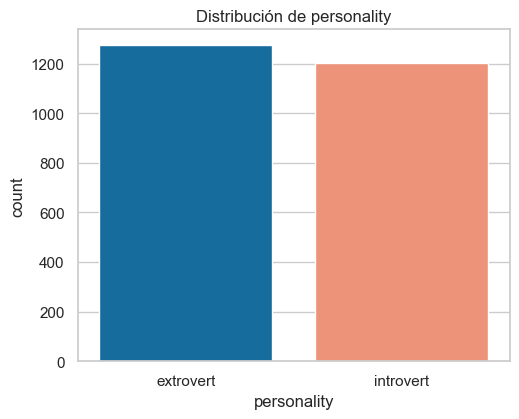

In [5]:
vs.pintar_grafico_barras_uni(df,[target],1)

#### **¿Cómo se distribuyen las variables categóricas?**

Anteriormente, en la exploración se observó como ambas variables estaban fuertemente correlacionadas. Es por ello, que los resultados obtenidos a la hora de ver su distribución, son iguales para ambas categorías.

Esto se debe a que todas aquellas personas con pánico escénico se sienten agotadas después de socializar y viceversa, y aquellas que no tienen pánico escénico no se sienten agotadas después de socializar.

La variable *stage_fear* presenta un 50,1% de personas sin pánico escénico y un 49,9% que sí que lo tienen, por lo tanto en este caso ambas categorías están prácticamente igualmente representadas.

Del mismo modo sucede con la variable *drained_after_socializing* cuyos resultados obtenidos son los mismos que los de la variable anterior. Esto significa que esta variable también se representa de forma muy balanceada.

In [6]:
df['stage_fear'].value_counts(normalize = True)

stage_fear
no     0.501009
yes    0.498991
Name: proportion, dtype: float64

In [7]:
df['drained_after_socializing'].value_counts(normalize = True)

drained_after_socializing
no     0.501009
yes    0.498991
Name: proportion, dtype: float64

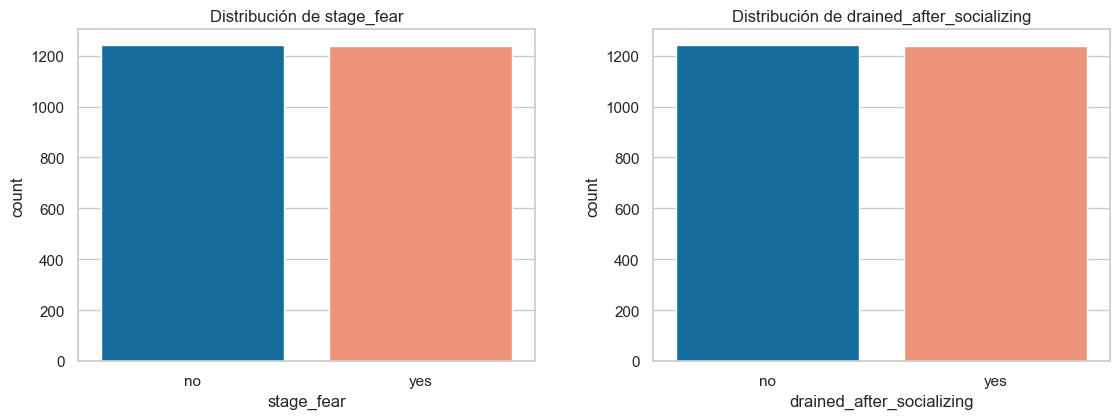

In [8]:
vs.pintar_grafico_barras_uni(df,categoricas)

#### **¿Cómo se distribuyen las variables numéricas?**

Gracias a los gráficos que se muestrana a continuación se observa que ninguna de las variables numéricas presenta una distribución normal, por lo que para aplicar modelos predictivos sería necesario normalizar estos datos.

Además, en la exploración inicial se observó que tampoco existían valores atípicos en ninguna de las variables.

La variable *time _spent_alone* presenta una distribución bimodal asimétrica, lo que refleja que hay un grupo predominante de personas que pasan pocas horas solos mientras que el otro grupo, con valores más dispersos, pasa más tiempo solo. Esto evidencia la existencia de heterogeneidad en los patrones de comportamiento.

Por otro lado, la variable *social_event_attendance* presenta una distribución decreciente similar a la distribución logarítmica, en la que la mayoría de las personas asisten pocas veces a eventos mientras que pocas personas asisten a estos eventos en mayor medida. Destaca un pequeño grupo con asistencia alta lo que representa un valor extremo, pero no un *outlier*.

En cuanto a la variable *going_outside* destacan dos picos marcados, lo que nos indica que sigue una distribución bimodal lo que sugiere la existencia de dos subgrupos dentro de la población de estudiantes.

Respecto a *friends_circle_size* tiene una distribución asimétrica y sesgada a la derecha. Esto se ve representado con un pico que hace referencia a que la mayoría de los estudiantes tienen pocos amigos. Después de ello, la frecuencia disminuye y se mantiene relativamente constante hasta llegar a una minoría de personas con muchos amigos.

*Post_frecuency* sigue una distribución parecida a *social_event_attendance* por lo que es similar a una distribucion logarítmica pero mucho más marcada que en el caso de asistencia a eventos. En este caso, la mayoría de personas apenas postean en redes sociales mientras que el resto publican más de 3 veces. También existe una caída abrupta que indica la existencia de un valor extremo correspondiente a un pequeño grupo de personas que postean 10 veces.


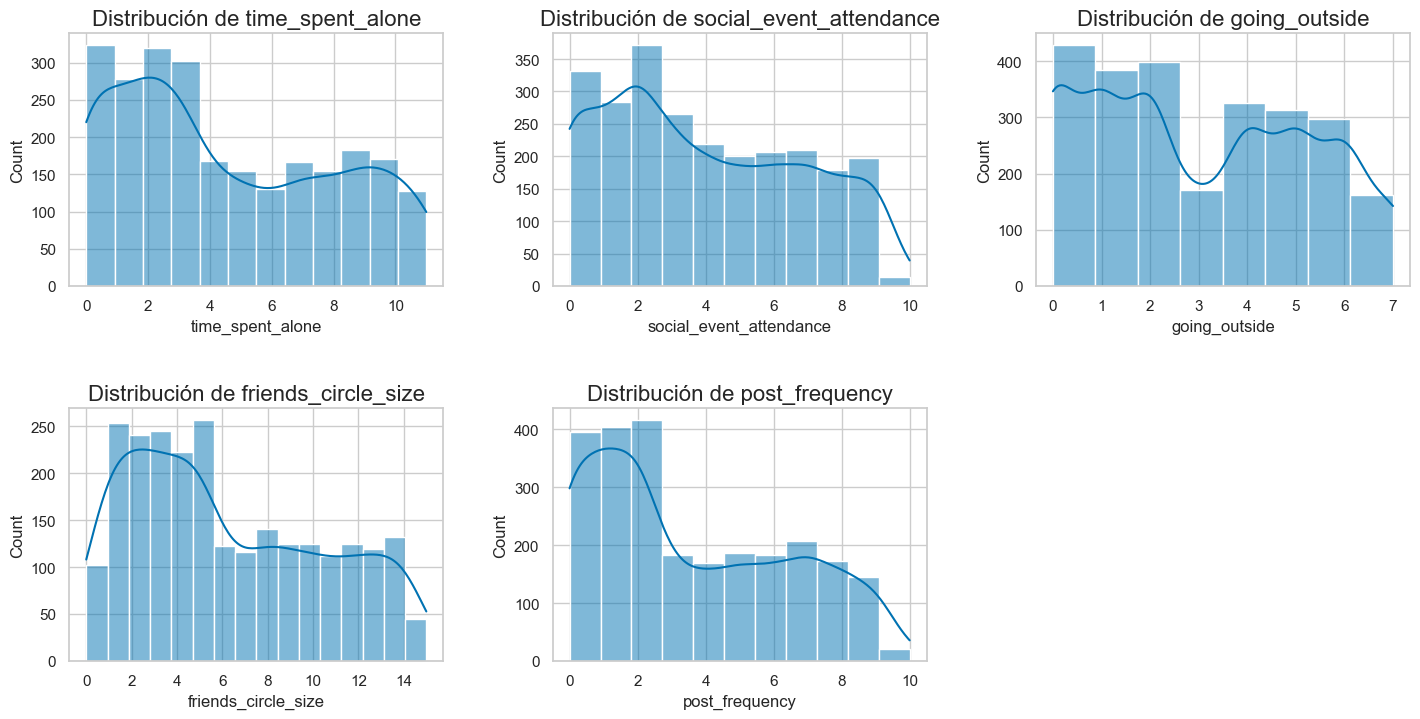

In [9]:
vs.pintar_distrib_num_uni(df,numericas)

En conclusión, las variables numéricas no siguen distribuciones normales. Algunas presentan bimodalidad como *time_spent_alone* y *going_outside*, lo que indica la existencia de subgrupos. Otras como *social_event_attendance*, *friends_circle_size* o *post_frecuency* muestran distribuciones sesgadas a la derecha donde la mayoría de los estudiantes tienen valores bajos y el resto presentan valores altos, incluyendo casos extremos.

También se refleja gran variabilidad entre los individuos por lo que hay heterogeneidad en los patrones de comportamiento de la muestra. 

En conjunto, las observaciones sugieren la existencia de agrupaciones por distintos tipos de comportamiento. 

### 2. Análisis bivariante

Aquí se analizarán pares de variables para ver su comportamiento de una en base a otra. Las preguntas que se van a responder son:
- Las personas introvertidas, ¿tienen pánico escénico?
- ¿Las personas que más publican en redes sociales son extrovertios o introvertidos? ¿Existen datos atípicos?
- ¿Cuantos amigos tienen las personas que se sienten agotadas después de socializar? ¿Y las que no? 
- ¿Existe alguna relación entre el tiempo que pasan a solas y el número de amigos?
- ¿Cuáles son las variables que explican mejor la variable objetivo?

#### **Las personas introvertidas, ¿tienen pánico escénico?**

Tal y como se muestra continuación, el 94% de las personas introvertidas tienen miedo escénico mientras que el 6% restante de este grupo no lo tienen. Por otro lado, en el grupo de extrovertidos, el 91% de las personas no tienen pánico escénico, quedándo un 6% de personas que sí lo tienen.

Estos resultados nos llevan a unos claros patrones que indican que las personas extrovertidas no suelen tener pánico escénico mientras que las introvertidas, en su mayoría, sí que lo poseen.

In [10]:
df.groupby('personality')['stage_fear'].value_counts(normalize=True)

personality  stage_fear
extrovert    no            0.914443
             yes           0.085557
introvert    yes           0.936825
             no            0.063175
Name: proportion, dtype: float64

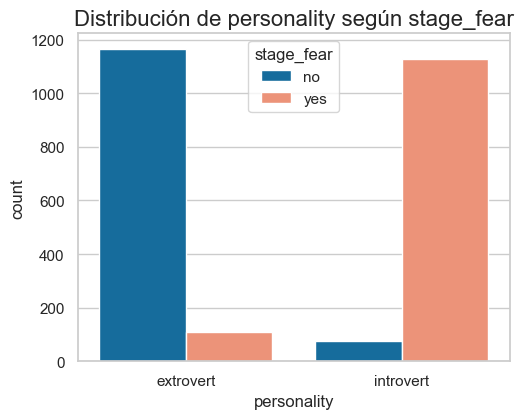

In [11]:
vs.grafico_barras_categoricas_target(df,['stage_fear'],target,1)

#### **¿Las personas que más publican en redes sociales son extrovertios o introvertidos? ¿Existen datos atípicos?**

Se observa que la mediana de las publicaciones en redes sociales de las personas introvertidas está en 1, mientras que las extrovertidas se sitúa en 6 publicaciones. Esto indica que las personas extrovertidas tieneden a publicar más que las introvertidas. Por otro lado, los rangos intercuartílicos de las personas extrovertidas son superiores a los de las personas introvertidas, lo que indica dos comportamientos muy diferenciados.

Sin embatrgo, dentro del grupo de introvertidos existen valores atípicos. Estos muestran la existencia de personas que publican de forma más activa, lo que refleja una variabilidad de comportamiento para personas con este rasgo de personalidad.

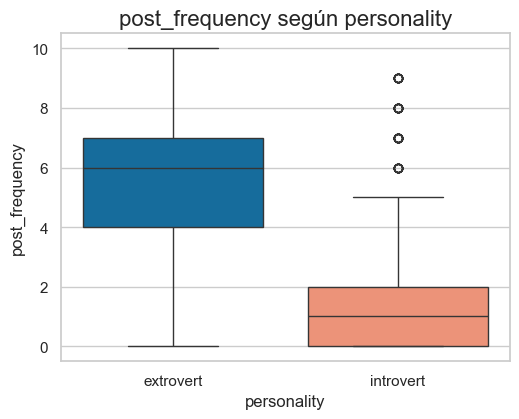

In [12]:
vs.dibujar_boxplot(df,'personality',['post_frequency'],1)

Por lo tanto, el número de publicaciones difiere entre los grupos. Además, dentro de los introvertidos existe más heterogeneidad a la hora de comportarse ya que hay presencia de outliers. A pesar de ello, ambos grupos siguen las tendencias esperadas: los extrovertidos publican más veces en redes sociales que los introvertidos. 

#### **¿Cuántos amigos tienen las personas que se sienten agotadas después de socializar? ¿Y las que no?**
Las personas que no se sienten agotadas después de socializar sitúa sus valores medios en 10 amigos, coincidiendo con la mediana. Además sus rangos intercuartílicos van desde los 7 hasta los 12 amigos. El máximo se sitúa en los 15 amigos.

Por otro lado, aquellos que sí se sienten agotados después de socializar tienen de media 3 amigos, coincidiendo también con su mediana. En este caso, los rangos intercuartílicos son inferiores respecto al grupo anterior, situándose entre 1 y 4 amigos, pudiéndodo llegar como máximo a 5 amigos.

In [13]:
(df.groupby('drained_after_socializing')['friends_circle_size'].mean()).round()

drained_after_socializing
no     10.0
yes     3.0
Name: friends_circle_size, dtype: float64

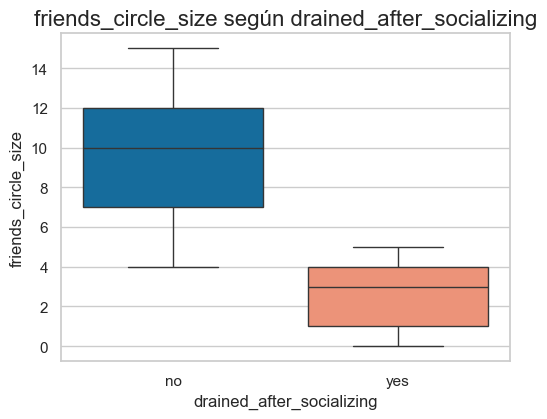

In [14]:
vs.dibujar_boxplot(df,'drained_after_socializing',['friends_circle_size'],1)

Todo ello, muestra que sentirse o no agotado después de socializar está relacionado con el número de amigos, ya que personas con pocos amigos tienden a sentirse agotados después de relacionarse mientras que aquellos con muchos amigos no presentan este comportamiento.

También cabe destacar que el mínimo de personas que componen el círculo de amigos de una persona que no se agota después de socializar coincide con el límite superior del rango intercuartílico del grupo perteneciente a aquellos que sí se sienten de este modo. Esto indica la existencia de baja superposición entre grupos. 

Por lo tanto, el tamaño del círculo de amigos es un rasgo que distingue claramente a ambos grupos, mostrando valores significativamente mayores para aquellos que no se sienten agotados después de socializar.

#### **¿Existe alguna relación entre el tiempo que pasan a solas y el número de amigos?**
Obteniendo la correlación entre las variables *time_spent_alone* y *friends_circle_size* se observa la existencia de una fuerte correlación negativa, lo que significa que cuanto mayor es el círculo de amigos menos tiempo pasan a solas.

Por otro lado, gracias al mapa de calor se distinguen dos concentraciones claras de valores, lo que sugiere la existencia de dos grupos. El primero de ellos permite acotar el círculo de amigos entre 0 y 5 amigos para personas que pasan solas entre 4 y 11 horas. El segundo, engloba a aquellas personas que poseen más de 5 amigos y que están a solas menos de 3 horas.

In [15]:
df[['time_spent_alone', 'friends_circle_size']].corr()

,time_spent_alone,friends_circle_size
time_spent_alone,1.000000,-0.717649
friends_circle_size,-0.717649,1.000000


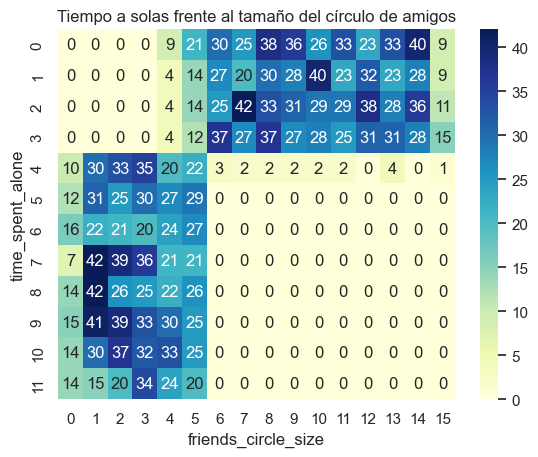

In [16]:
tabla = pd.crosstab(df['time_spent_alone'], df['friends_circle_size'])
sns.heatmap(tabla, annot=True, fmt="d",cmap = "YlGnBu")
plt.title('Tiempo a solas frente al tamaño del círculo de amigos')
plt.show()

Por lo tanto, existen dos patrones de comportamiento diferenciados: un grupo con altos valores de tiempo a solas pero bajo en el círculo de amigos y otro con el patrón inverso.

#### **¿Cuáles son las variables que explican mejor la variable objetivo?**

Para identificar qué variables explican mejor la variable objetivo debemos dividirlo entre categóricas y numéricas ya que cada una requiere un análisis diferente.

En el caso de las **variables numéricas** se ha optado por el cálculo del p-value mediante t-test y su representación mediante boxplots. Los resultados obtenidos del p-value en todas las variables son próximos a 0. Al ser un valor inferior a 0.05 significa que todas ellas son significativas a la hora de explicar la personalidad. En cuanto a la diferencia de medianas y sus rangos intercuartílicos también es muy significativa entre grupos, presentando valores más altos en los grupos de extrovertidos a excepción de la variable *time_spent_alone* donde se invierte este comportamiento.

Por otro lado, al representar los diagramas de caja se observa un comportamiento peculiar, mayormente en el grupo de introvertidos. Esto se debe a que todas las variables numéricas excepto *time_spent_alone*, presentan valores atípicos en valores superiores, lo que implica que dentro de este grupo hay mucha variabilidad. Sin embargo, el grupo de extrovertidos solo presenta outliers para valores inferiores en el tiempo que pasan solos y en salir fuera, lo cual es lógico porque al ser una investigación hecha a estudiantes lo normal es que pasen más tiempo a solas para dedicarlo a sus tareas lectivas.

En cuanto a las **variables categóricas** se han usado tablas de contingencia y la prueba del chi-cuadrado junto con la representación de ambas variables en gráficos de barra. Al igual que con las numéricas, al obtener el p-value ambas variables presentan un valor de 0 lo que significa que se rechaza la hipótesis nula y por tanto ambas son variables signifiativas. Además en los gráficos podemos ver como son distribuciones completamente opuestas para introvertidos y extrovertidos, lo cual confirma más que estas variables son significativas.

In [17]:
vs.obtener_p_value (df,target,'introvert','extrovert',numericas)

P-value de time_spent_alone = 0.0
P-value de social_event_attendance = 0.0
P-value de going_outside = 0.0
P-value de friends_circle_size = 0.0
P-value de post_frequency = 0.0


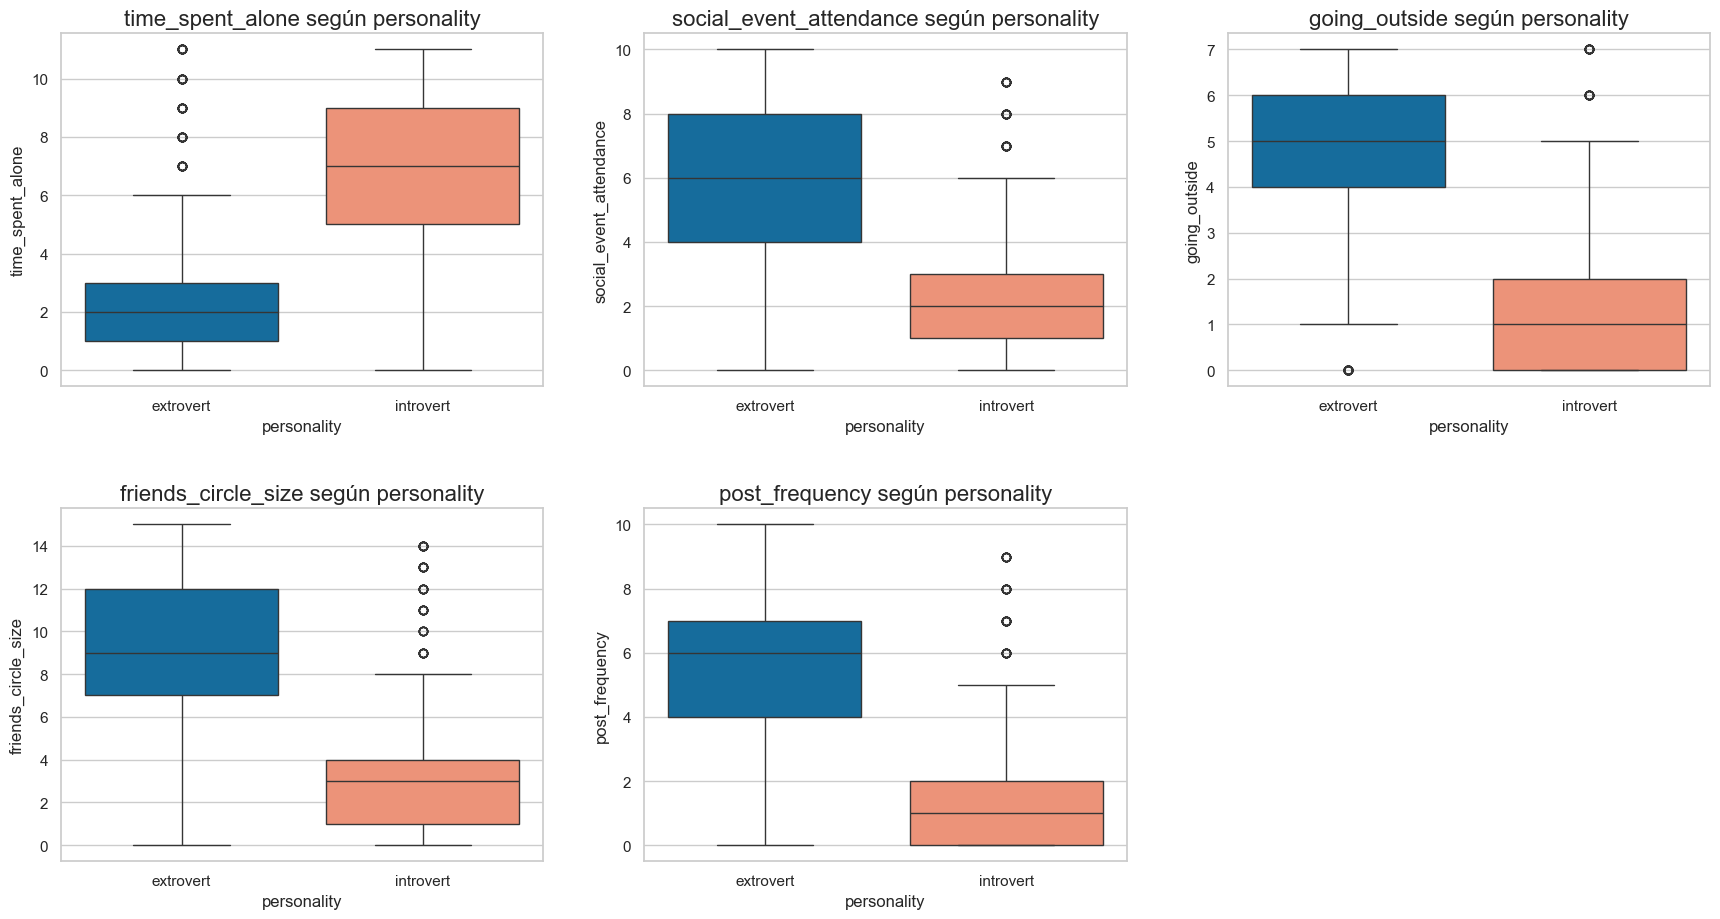

In [18]:
vs.dibujar_boxplot(df,target,numericas)

In [19]:
vs.calculo_tabla_contingencia_chi2(df,target,categoricas)

stage_fear     no   yes
personality            
extrovert    1165   109
introvert      76  1127

P-value de stage_fear = 0.0
--------------------------
drained_after_socializing    no   yes
personality                          
extrovert                  1165   109
introvert                    76  1127

P-value de drained_after_socializing = 0.0
--------------------------


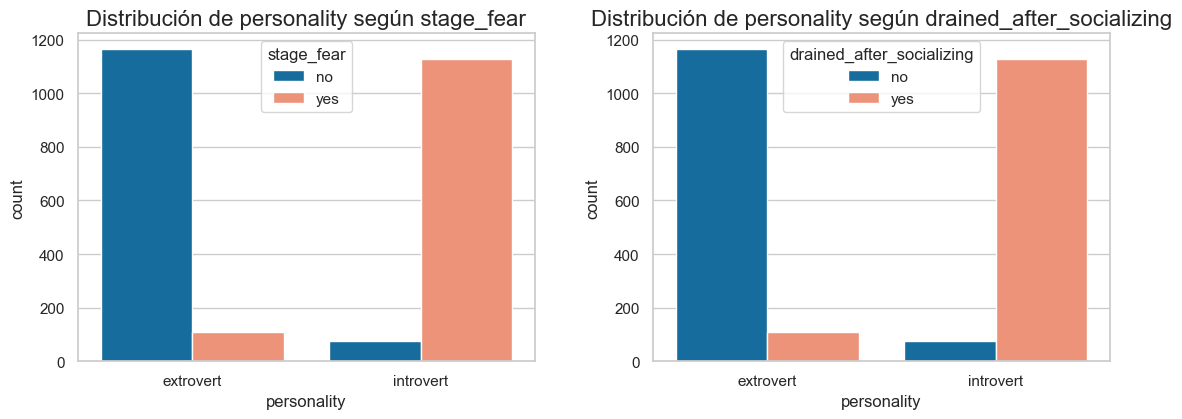

In [20]:
vs.grafico_barras_categoricas_target(df,categoricas,target)

En conclusión, todas las pruebas estadísticas junto con sus representaciones graficas nos indian que todas las variables son significativas, es decir, son capaces de discriminar entre grupos respecto a la personalidad ya que todas aportan imformación sobre el target. Esto será útil a la hora de seleccionar features para realizar modelos predictivos.

### 3. Análisis multivariante

Por último, en el análisis multivariante se examinarán tres o más variables a la vez para ver como se relacionan entre sí.

Las preguntas a contestar son:
- ¿Existe algún perfil multivariante, dentro de las variables numéricas, que defina la personalidad de un individuo?
- ¿Cómo se relacionan simultaneamente el tiempo a solas, el número de amigos y la frecuencia de publicaciones?

#### **¿Existe algún perfil multivariante, dentro de las variables numéricas, que defina la personalidad de un individuo?**
Para contestar a esta pregunta se ha realizado tanto un gráfico de barras con las medias de cada grupo de personalidad para las variables numéricas y un pairplot. 
En primer lugar, existen claras diferencias en cuanto a las medias de todas las variables agrupadas por la variable *personality*. A excepción de *time_spent_alone*, las medias obtenidas para el grupo de extrovertidos presenta valores superiores.

En cuanto al pairplot, al ser variables discretas, se observan "cuadrados" de puntos, dentro de los cuales cada uno corresponde en su mayoría a un grupo de la variable *personality*. Esto indica que los valores de estas variables están asociados a un tipo de personalidad, por lo que se confirma la existencia de un perfil multivariante.  

Es importante destacar el comportamiento de la variable *going_outside*, en cuya diagonal aparece una representación más similar lo que sugiere que esta variable discrimina menos que el resto, pero sigue aportando información.

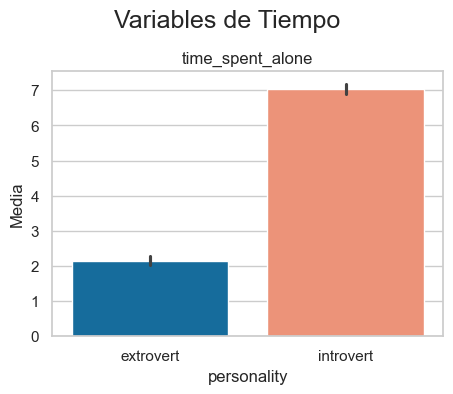

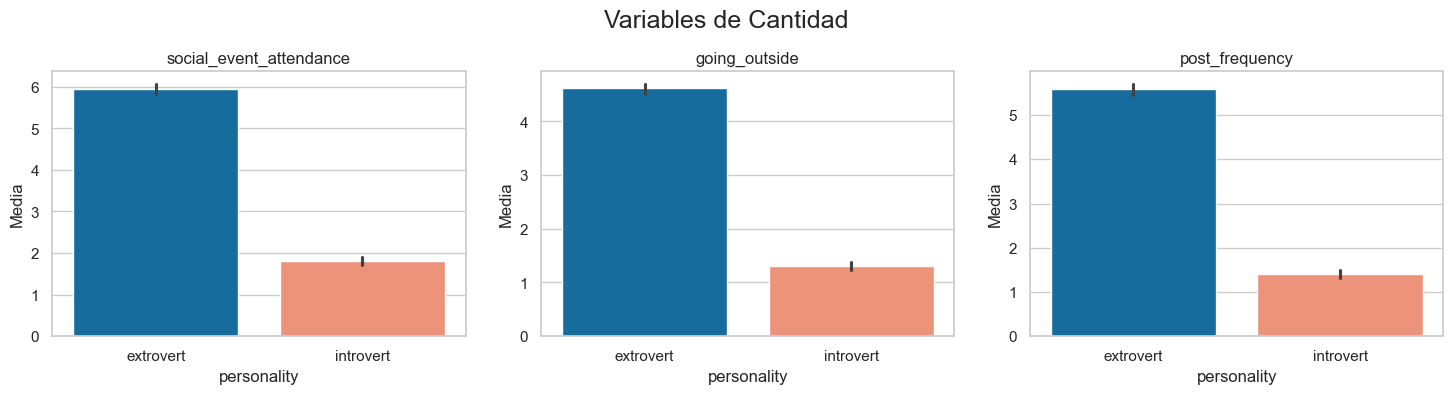

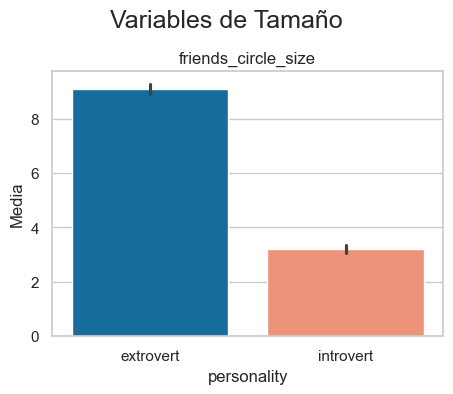

In [21]:
vs.dibujar_medias_por_grupo(df, target, numericas)

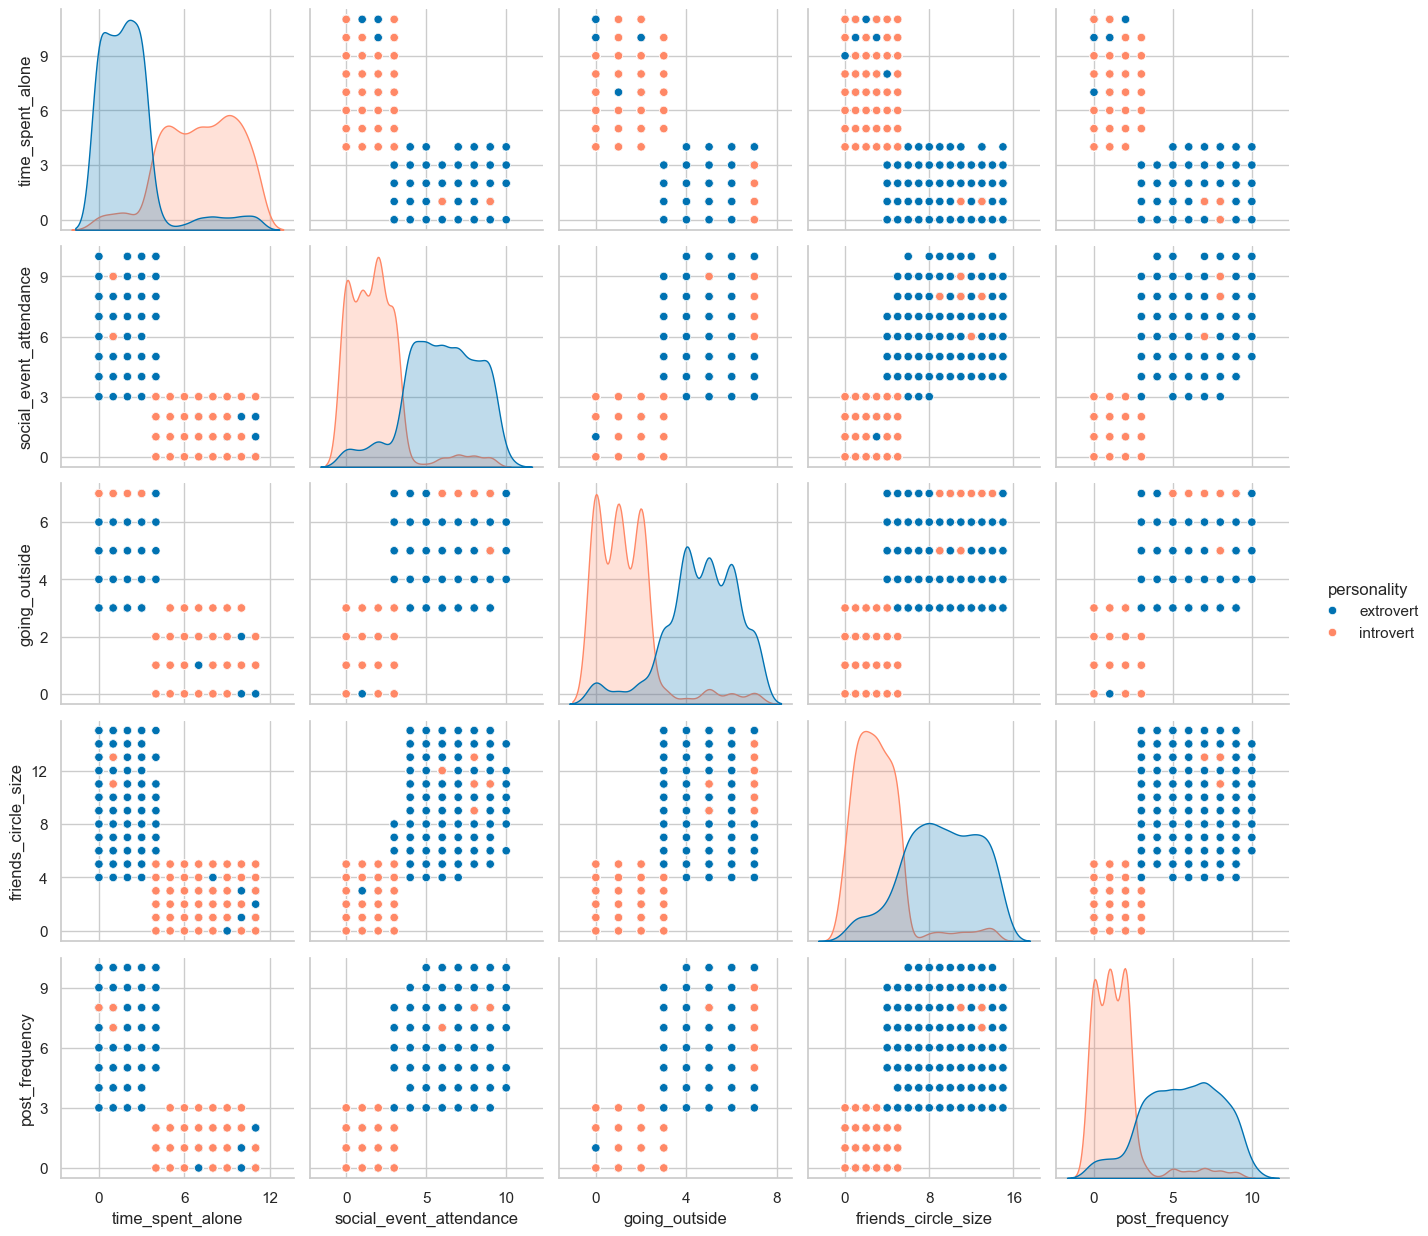

In [22]:
vs.dibujar_pairplot(df,'personality',numericas)

En conclusión, el análisis multivariante muestra como las variables numéricas muestran perfiles diferenciados de los estudiantes según su tipo de personalidad ya que los valores de las variables permiten discriminar consistentemente a introvertidos y extrovertidos.

#### **¿Cómo se relacionan simultaneamente el tiempo a solas, el número de amigos y la frecuencia de publicaciones?**

Para analizar como se relacionan simultaniamente las variables *"time_spent_alone", "friends_circle_size", "post_frequency"* se ha utilizado una matriz de correlacion para ver si existen relaciones positivas o negativas entre ellas.

A rasgos generales todas ellas están fuertemente correlacionadas pero difiere el tipo de correlación. En primer lugar, *time_spent_alone* está correlacionado negativamente con *friends_circle_size* y con *post_frecuency*, es decir que cuanto más tiempo pasa sola una persona menos amigos tiene y menos publica en redes sociales. Sin embargo, el círculo de amigos se relaciona de forma negativa con el tiempo que pasa solo y de forma positiva con la frecuencia de publicaciones lo que implica que una persona con muchos amigos publica más que otra que tiene menos y pasa menos tiempo sola. Del mismo modo le sucede a una persona que hace muchas publicaciones, las cuales suelen tener más amigos y dedican menos tiempo para estar solas.

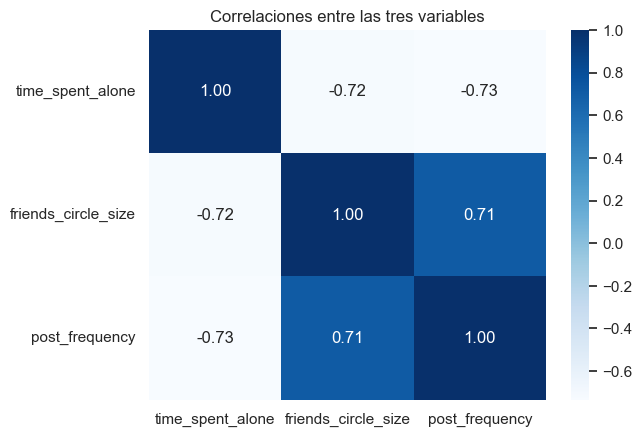

In [23]:
corr = df[["time_spent_alone", "friends_circle_size", "post_frequency"]].corr()

sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlaciones entre las tres variables")
plt.show()

Por lo tanto todas están correlacionadas fuertemente entre ellas, pero *time_spent_alone* lo hace de forma negativa con las otras dos, mientras que *friends_circle_size* y *post_frecuency* se correlacionan de forma positiva entre ellas.

### 4. Conclusiones finales

El análisis revela que el dataset está balanceado, con variables numéricas discretas y categóricas que permiten diferenciar los grupos de personalidad. Los patrones multivariantes y los valores medios obtenidos por grupos muestran perfiles distintos para personas introvertidas y extrovertidas, lo que indica que las variables son útiles para caracterizar y diferenciar ambos grupos de manera consistente.